# Imports

In [1]:
from torchqrnn import QRNN, QRNNLayer

In [2]:
from pprint import pprint
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe
import time

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, Conv1d
import torch.nn.functional as F

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools
sns.set(style="darkgrid")

import warnings
warnings.filterwarnings('ignore')

DATA_DIRECTORY = "data/"

In [3]:
use_cuda = torch.cuda.is_available()
def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

print(f"Using CUDA: {use_cuda}")

Using CUDA: True


# Importing data and building vocabulary

In [4]:
#Initialize the two fields: Sequence and Class
SEQ = data.Field(sequential=True,include_lengths=True, unk_token='N')
LABEL = data.Field(sequential=False, unk_token='1') # is_target = True ?

train_set, validation_set, test_set = data.TabularDataset.splits(path='',
                                                                 train=DATA_DIRECTORY+'train_filtered.txt',
                                                                 validation=DATA_DIRECTORY+'val_filtered.txt',
                                                                 test=DATA_DIRECTORY+'val_filtered.txt', 
                                                                 format = 'csv',
                                                                 fields=[('sequence', SEQ), ('label', LABEL)])

# build the vocabularies
SEQ.build_vocab(train_set, min_freq=2) #NO unknows 
LABEL.build_vocab(train_set, )

# Creating training and validation iterators
Note that as we did not have time for nested cross-validation, we do not use three separate sets.

In [5]:
BATCH_SIZE = 4

train_iter = data.BucketIterator(train_set,
                                 batch_size=BATCH_SIZE, 
                                 device=torch.device("cuda:0" if use_cuda else "cpu"),
                                 sort_key=lambda x: len(x.sequence), #Sorting within the batch
                                 sort = True,
                                 shuffle = True,
                                 repeat = False
                                )

validation_iter = data.BucketIterator(validation_set,
                                 batch_size=BATCH_SIZE, 
                                 device=torch.device("cuda:0" if use_cuda else "cpu"),
                                 sort_key=lambda x: len(x.sequence), #Sorting within the batch
                                sort = True,
                                repeat = False
                                )


# Setting up network

In [6]:
# size of embeddings
EMBEDDING_DIM = 8
NUM_EMBEDDING = len(SEQ.vocab) #size of vocab 
NUM_CLASSES = len(LABEL.vocab.itos)
CONV_CHANNELS = 64
HIDDEN_DIM = 1024   # incorrectly stated as 512 in the paper.
NUM_LAYERS_QRNN = 2
STRIDE = 3


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.embeddings = nn.Embedding(NUM_EMBEDDING, EMBEDDING_DIM)
        self.conv1 = Conv1d(in_channels= EMBEDDING_DIM,
                            out_channels= CONV_CHANNELS,
                            padding=1,
                            kernel_size=3,
                            stride=STRIDE)

        
        self.qrnn1 = QRNN(CONV_CHANNELS, HIDDEN_DIM, num_layers=NUM_LAYERS_QRNN, window=1, zoneout=0.1)
        self.qrnn2 = QRNN(CONV_CHANNELS, HIDDEN_DIM, num_layers=NUM_LAYERS_QRNN, window=1, zoneout=0.1)
        self.qrnn1.cuda()
        self.qrnn2.cuda()
        
        self.linear = Linear(in_features=2*HIDDEN_DIM,
                            out_features=NUM_CLASSES)
        
        self.lin_dropout = torch.nn.Dropout(p=0.3)
        
        
        self.hidden = self.init_hidden(BATCH_SIZE)
        
    def forward(self, x):
        sequences = x[0]
        lengths = x[1]
        
        # get embeddings
        x = self.embeddings(sequences)
        x = x.permute([1,2,0])
        x = F.relu(self.conv1(x))
    
        # created flipped sequence
        x1 = x.permute([2,0,1])
        x2 = torch.flip(x1,(0,))  
        
        
        # rnn returns output and last hidden state
        _, x1 = self.qrnn1(x1)
        _, x2 = self.qrnn2(x2)
        
        # concatenation
        x = torch.cat((x1,x2), 2)
        
        x = self.lin_dropout(x)
        x = F.relu(x[-1].type(torch.float))
        
        freqs = F.softmax(self.linear(x))
        return freqs
    
    
    def init_hidden(self, batch_size):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(NUM_LAYERS_QRNN, BATCH_SIZE, HIDDEN_DIM),
                torch.zeros(NUM_LAYERS_QRNN, BATCH_SIZE, HIDDEN_DIM))
    
    
net = Net()

def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

net.apply(weights_init)


if use_cuda:
    net.cuda()
    print("using cuda")
print(net)

using cuda
Net(
  (embeddings): Embedding(6, 8)
  (conv1): Conv1d(8, 64, kernel_size=(3,), stride=(3,), padding=(1,))
  (qrnn1): QRNN(
    (layers): ModuleList(
      (0): QRNNLayer(
        (linear): Linear(in_features=64, out_features=3072, bias=True)
      )
      (1): QRNNLayer(
        (linear): Linear(in_features=1024, out_features=3072, bias=True)
      )
    )
  )
  (qrnn2): QRNN(
    (layers): ModuleList(
      (0): QRNNLayer(
        (linear): Linear(in_features=64, out_features=3072, bias=True)
      )
      (1): QRNNLayer(
        (linear): Linear(in_features=1024, out_features=3072, bias=True)
      )
    )
  )
  (linear): Linear(in_features=2048, out_features=6, bias=True)
  (lin_dropout): Dropout(p=0.3)
)


# Import trained architecture?

In [7]:
LOAD_MODEL = True

if LOAD_MODEL:
    net.load_state_dict(torch.load("pretrained models/model1.txt"))

# Set up optimizer, loss function, etc

In [8]:
# check which params require grad
print("List of gradient-requiring parameters in network")
{p[0]: p[1].requires_grad for p in net.named_parameters()}

List of gradient-requiring parameters in network


{'embeddings.weight': True,
 'conv1.weight': True,
 'conv1.bias': True,
 'qrnn1.layers.0.linear.weight': True,
 'qrnn1.layers.0.linear.bias': True,
 'qrnn1.layers.1.linear.weight': True,
 'qrnn1.layers.1.linear.bias': True,
 'qrnn2.layers.0.linear.weight': True,
 'qrnn2.layers.0.linear.bias': True,
 'qrnn2.layers.1.linear.weight': True,
 'qrnn2.layers.1.linear.bias': True,
 'linear.weight': True,
 'linear.bias': True}

In [9]:
loss_weights = [1/5531, 1/3486 ,1/2874, 1/1578, 1/814, 1/328]
loss_weights = torch.Tensor([item/sum(loss_weights) for item in loss_weights])
criterion = nn.CrossEntropyLoss(weight=loss_weights.cuda()) #weight = final_weights
# we filter the model's parameters such that we can remove the embedding layer, 
# which does not have requires_grad
optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.0001)


def accuracy(ys, ts):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    #print(ys)
    #print(ts)
    correct_prediction = torch.eq(torch.max(ys, 1)[1], ts)
#     print(torch.max(ys, 1)[1], ts)
#     print(correct_prediction)
    # averaging the one-hot encoded vector
    return torch.mean(correct_prediction.float())

In [10]:
# check memory used so far
torch.cuda.memory_allocated() 

53689856

# Training. Skipping section if using pre-trained model

In [11]:
if not LOAD_MODEL:
    num_epoch = 60
    iter_by_epoch = int(len(train_set)/BATCH_SIZE)
    eval_every = 1000

    reduced_train_lost = []
    reduced_train_accuracy = []

    reduced_val_lost = []
    reduced_val_accuracy = []

    times = []
    epoch_index = []
    i = 0


    for epoch in range(num_epoch):

        train_loss, train_accs = [], []
        val_loss, val_accs = [], []

        net.train()
        # Training
        for i, batch in enumerate(train_iter):

            optimizer.zero_grad()

            output = net(batch.sequence)
            batch_loss = criterion(output, batch.label)

            batch_loss.backward()     
            optimizer.step()

            train_loss.append(get_numpy(batch_loss.detach()))
            train_accs.append(get_numpy(accuracy(output, batch.label).detach()))

            if i % eval_every == 0:     
                #print(f"OUTPUT:{output}")

                net.eval()
                val_losses_running, val_accs_running, val_lengths = 0, 0, 0

                for val_batch in validation_iter:
                    output = net(val_batch.sequence).detach()
                    val_losses_running += criterion(output, val_batch.label)*val_batch.batch_size
                    val_accs_running += accuracy(output, val_batch.label)*val_batch.batch_size
                    val_lengths += val_batch.batch_size

                # divide by the total accumulated batch sizes
                val_losses_running /= val_lengths
                val_accs_running /= val_lengths
                val_loss.append(get_numpy(val_losses_running))
                val_accs.append(get_numpy(val_accs_running))
                net.train()


        reduced_train_lost.append(np.mean(train_loss))
        reduced_train_accuracy.append(np.mean(train_accs))

        reduced_val_lost.append(np.mean(val_loss))
        reduced_val_accuracy.append(np.mean(val_accs))

        epoch_index.append(epoch)
        times.append(time.time())

        print(f'\nEpoch {epoch}\tTrain {np.mean(train_loss):.3f}\tVal {np.mean(val_loss):.3f}\tTAcc {np.mean(train_accs):.3f}\tVAcc {np.mean(val_accs):.3f}\n')

In [12]:
if not LOAD_MODEL:
    fig = plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_index,reduced_train_lost,label='train_loss')
    plt.plot(epoch_index,reduced_val_lost, label='valid_loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epoch_index, reduced_train_accuracy, label='train_accs')
    plt.plot(epoch_index, reduced_val_accuracy, label='valid_accs')
    plt.legend()
    plt.show()
    fig.savefig(str(time.time())+".svg", format="svg")

# Take a look at validation data (this may take some time)

In [13]:
net.eval()
valid_loss = []
valid_accs = []

val_losses, val_accs, val_lengths = 0, 0, 0
predictions = []
real_values = []


for val_batch in validation_iter:
    output = net(val_batch.sequence).detach()
    predictions.extend([LABEL.vocab.itos[int(i)] for i in torch.max(output,1)[1]])
    real_values += [LABEL.vocab.itos[int(i)] for i in val_batch.label]
    val_losses += criterion(output, val_batch.label)*val_batch.batch_size
    val_accs += accuracy(output, val_batch.label) *val_batch.batch_size
    val_lengths += val_batch.batch_size

# divide by the total accumulated batch sizes
val_losses /= val_lengths
val_accs /= val_lengths
valid_loss.append(get_numpy(val_losses))
valid_accs.append(get_numpy(val_accs))
net.train()

Net(
  (embeddings): Embedding(6, 8)
  (conv1): Conv1d(8, 64, kernel_size=(3,), stride=(3,), padding=(1,))
  (qrnn1): QRNN(
    (layers): ModuleList(
      (0): QRNNLayer(
        (linear): Linear(in_features=64, out_features=3072, bias=True)
      )
      (1): QRNNLayer(
        (linear): Linear(in_features=1024, out_features=3072, bias=True)
      )
    )
  )
  (qrnn2): QRNN(
    (layers): ModuleList(
      (0): QRNNLayer(
        (linear): Linear(in_features=64, out_features=3072, bias=True)
      )
      (1): QRNNLayer(
        (linear): Linear(in_features=1024, out_features=3072, bias=True)
      )
    )
  )
  (linear): Linear(in_features=2048, out_features=6, bias=True)
  (lin_dropout): Dropout(p=0.3)
)

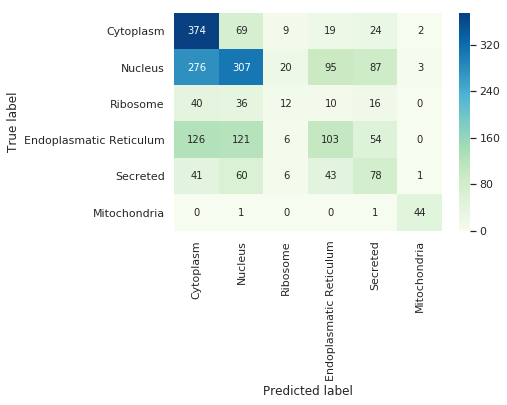

By class accuracies :

[0.75 0.39 0.11 0.25 0.34 0.96]
total accuracy :

0.44049904030710174


In [14]:
#Stupid modification to get order in confusion matrix
cnf_matrix = confusion_matrix(real_values, predictions)
np.set_printoptions(precision=2)

ax = plt.axes()

sns.heatmap(cnf_matrix,annot=True, cmap= "GnBu",fmt="d", xticklabels = ["Cytoplasm", "Nucleus", "Ribosome", "Endoplasmatic Reticulum", "Secreted", "Mitochondria"], yticklabels = ["Cytoplasm", "Nucleus", "Ribosome", "Endoplasmatic Reticulum", "Secreted", "Mitochondria"])
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')
# plt.savefig("double_lstm_confusion.png")
plt.show()

cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print("By class accuracies :\n")
print(cm.diagonal())

print("total accuracy :\n")
print(accuracy_score(real_values, predictions))